# Logistic Regression Predicitons

Notebook to explore logistic regression applied to football match prediction

## 1. Imports

In [14]:
# mixture of libs for web scraping, parsing and pandas
import datetime as dt
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import warnings

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from epl.query import create_and_query
from epl.match_utils import full_table_calculator, league_table_asof, result_calculator, table_calculator
from epl.feature_utils import add_game_week, add_league_pos, add_prev_season_pos, add_result_streak, add_avg_ppg

pd.options.display.max_columns = None
pd.options.display.max_rows = 100
warnings.filterwarnings('ignore')

In [2]:
df_raw = create_and_query('matches', cols=['Div', 'Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'B365H', 'B365D', 'B365A'])
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw = df_raw.sort_values('Date', ascending=True)
df_raw.tail()

Running query: SELECT Div, Season, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR, B365H, B365D, B365A FROM matches 


,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A
200,E3,2020/2021,2020-10-13,Cheltenham,Grimsby,1.0,3.0,A,1.72,3.90,4.60
243,EC,2020/2021,2020-10-13,Woking,Dag and Red,2.0,0.0,H,3.60,3.50,2.00
242,EC,2020/2021,2020-10-13,Wealdstone,Stockport,2.0,5.0,A,3.75,3.75,1.90
240,EC,2020/2021,2020-10-13,Sutton,Notts County,0.0,1.0,A,3.00,3.30,2.37
237,EC,2020/2021,2020-10-13,Halifax,Yeovil,1.0,1.0,D,2.75,3.40,2.45


Will limit to only studying the top leagues

In [3]:
top_divs = ['E0', 'D1', 'B1', 'I1', 'F1', 'G1', 'N1', 'SC0', 'T1']
df_raw = df_raw[df_raw.Div.isin(top_divs)].dropna()

## 2. Benchmark

Before we try to make some predictions, we can have a look at how well the bookies do at predicting match outcomes

This can then serve as a benchmark if they perform well

It can also help us identify games that are 'difficult' to predict or general biases in our predictions

### 2a. The Bookies Markup

Bookies make money by taking spread - if they generate equal __payouts__ (not betted money) on either side they capture risk-free the whole spread

In [4]:
df_bookies = df_raw.copy()
df_bookies['Total_Odds'] = (1 / df_bookies.B365H) + (1 / df_bookies.B365D) + (1 / df_bookies.B365A)

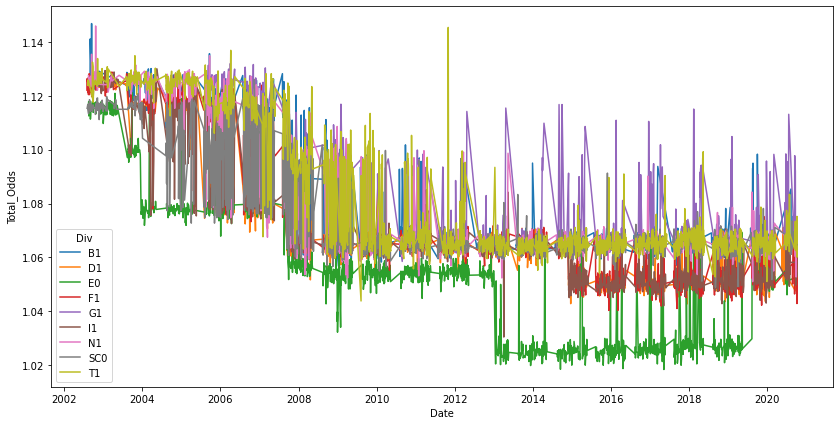

In [5]:
fig, ax = plt.subplots(figsize=(14,7))
sns.lineplot(data=df_bookies[['Div', 'Date', 'Total_Odds']].groupby(['Div', 'Date']).mean().reset_index(), x='Date', y='Total_Odds', hue='Div', ax=ax);

As we can see this spread has been decreasing over the last 20 years as the industry has become more competitive, more data is available and the rise of data science has helped to improve their prediciton accuracy

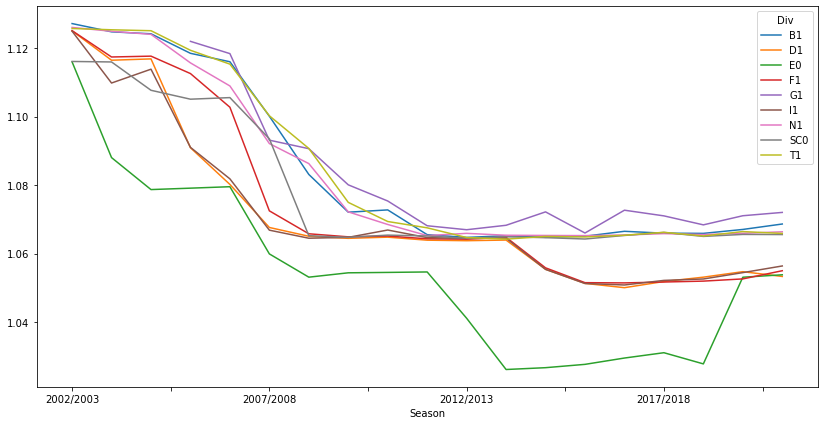

In [6]:
pd.pivot_table(data=df_bookies[['Div', 'Season', 'Total_Odds']].groupby(['Div', 'Season']).mean().reset_index(), index='Season', columns='Div', values='Total_Odds').plot(figsize=(14,7));

### 2b. Bookies Estimated Probabilities

1 over the odds gives us the estimated bookie probabilities of an outcome

We can compute these, bucket them and display 'actual probabilities' vs 'predicted probabilities' to see how well the bookies predict outcomes

In [7]:
df_bookies['ProbabHome'] = 1 / df_bookies['B365H']
df_bookies['ProbabAway'] = 1 / df_bookies['B365A']

In [8]:
num_bins = 50
bins = [x/num_bins for x in range(1, num_bins + 1)]

In [9]:
df_bookies['ProbabHomeBin'] = pd.cut(df_bookies['ProbabHome'], bins, labels=[round(x + (1/num_bins/2), 4) for x in bins[:-1]])
df_bookies['ProbabAwayBin'] = pd.cut(df_bookies['ProbabAway'], bins, labels=[round(x + (1/num_bins/2), 4) for x in bins[:-1]])
df_bookies

,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,Total_Odds,ProbabHome,ProbabAway,ProbabHomeBin,ProbabAwayBin
147049,F1,2002/2003,2002-08-02,Guingamp,Lyon,3.0,3.0,D,3.200,3.0,2.10,1.122024,0.312500,0.476190,0.31,0.47
147057,F1,2002/2003,2002-08-03,Strasbourg,Ajaccio,1.0,1.0,D,1.833,3.0,4.00,1.128887,0.545554,0.250000,0.55,0.25
147056,F1,2002/2003,2002-08-03,Sedan,Sochaux,0.0,0.0,D,2.000,3.0,3.40,1.127451,0.500000,0.294118,0.49,0.29
147055,F1,2002/2003,2002-08-03,Paris SG,Auxerre,1.0,0.0,H,1.833,3.0,4.00,1.128887,0.545554,0.250000,0.55,0.25
147054,F1,2002/2003,2002-08-03,Nice,Le Havre,1.0,2.0,A,1.909,3.0,3.75,1.123834,0.523834,0.266667,0.53,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182402,G1,2020/2021,2020-10-04,Panathinaikos,Aris,0.0,1.0,A,1.950,3.3,4.00,1.065851,0.512821,0.250000,0.51,0.25
152894,N1,2020/2021,2020-10-04,Groningen,Ajax,1.0,0.0,H,6.500,5.0,1.40,1.068132,0.153846,0.714286,0.15,0.71
61694,SC0,2020/2021,2020-10-04,St Johnstone,Celtic,0.0,2.0,A,10.000,6.0,1.25,1.066667,0.100000,0.800000,0.09,0.79
95502,I1,2020/2021,2020-10-04,Atalanta,Cagliari,5.0,2.0,H,1.250,6.5,10.00,1.053846,0.800000,0.100000,0.79,0.09


In [10]:
# separate into home and away win dfs
home_wins = df_bookies[df_bookies.FTR == 'H'][['FTR', 'ProbabHomeBin']].groupby(['ProbabHomeBin']).count()
all_games = df_bookies[['FTR', 'ProbabHomeBin']].groupby(['ProbabHomeBin']).count()
home_win_pc = (home_wins / all_games).reset_index()
home_win_pc = home_win_pc.astype(float)

away_wins = df_bookies[df_bookies.FTR == 'A'][['FTR', 'ProbabAwayBin']].groupby(['ProbabAwayBin']).count()
all_games = df_bookies[['FTR', 'ProbabAwayBin']].groupby(['ProbabAwayBin']).count()
away_win_pc = (away_wins / all_games).reset_index()
away_win_pc = away_win_pc.astype(float)

In [11]:
home_win_pc = home_win_pc.dropna()
home_win_pc.columns = ['BookiesProbab', 'RealisedHomeWins']
away_win_pc = away_win_pc.dropna()
away_win_pc.columns = ['BookiesProbab', 'RealisedAwayWins']

In [12]:
win_probab = pd.merge(left=home_win_pc, right=away_win_pc, how='outer', on='BookiesProbab')
win_probab = pd.melt(win_probab, id_vars=['BookiesProbab'], value_vars=['RealisedHomeWins', 'RealisedAwayWins'], var_name='HomeAway', value_name='Probab') 
win_probab['HomeAway'] = np.where(win_probab['HomeAway'] == 'RealisedHomeWins', 'Home', 'Away')

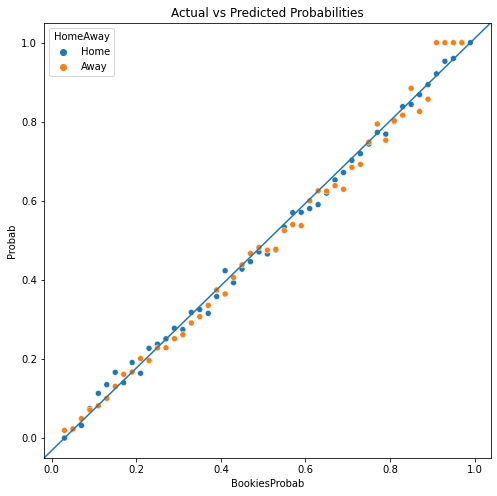

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=win_probab, x='BookiesProbab', y='Probab', hue='HomeAway', ax=ax);
ax.plot([0, 1], [0, 1], transform=ax.transAxes);
ax.set_title('Actual vs Predicted Probabilities');

As we can see, the bookies are very good at their job

As such, their estimated probabilities can serve as a good benchmark for our models and differences can be identified and investigated - potentially to discover newly important factors

## 3. Build Factors

Add on a few key factors that are potentially helpful to predict - we can investigate this post prediction

In [ ]:
# create new dataframe for prediction
df = df_raw.copy()

# add features
df = add_game_week(df)
df, tables_df = add_league_pos(df)
df = add_prev_season_pos(df, tables_df)

In [ ]:
'''df = add_result_streak(df, 3)
df = add_result_streak(df, 5)
df = add_result_streak(df, 10)
df = add_result_streak(df, 20)
df.head()
'''

df = add_avg_ppg(df, 3)
df = add_avg_ppg(df, 5)
df = add_avg_ppg(df, 10)
df = add_avg_ppg(df, 20)

In [ ]:
df.info()

## 4. Transform Data for Estimation

We have a multiclass problem - we want to predict W / D / L (instead of a binary classification problem of e.g. W / L)

In [351]:
df_est.head()

,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,Total_Odds,ProbabHome,ProbabAway,ProbabHomeBin,ProbabAwayBin,HomeTeamGameWeek,AwayTeamGameWeek,HomeTeamPoints,HomeLeagPos,AwayTeamPoints,AwayLeagPos,HomePrevLeagPos,AwayPrevLeagPos,HomeWStreak_3,HomeDStreak_3,HomeLStreak_3,AwayWStreak_3,AwayDStreak_3,AwayLStreak_3,HomeWStreak_5,HomeDStreak_5,HomeLStreak_5,AwayWStreak_5,AwayDStreak_5,AwayLStreak_5,HomeWStreak_10,HomeDStreak_10,HomeLStreak_10,AwayWStreak_10,AwayDStreak_10,AwayLStreak_10,HomeWStreak_20,HomeDStreak_20,HomeLStreak_20,AwayWStreak_20,AwayDStreak_20,AwayLStreak_20
2717,E0,2003/2004,2004-01-10,Portsmouth,Man City,4.0,2.0,H,2.50,3.25,2.7,1.078063,0.400000,0.370370,0.39,0.37,21.0,21.0,35.0,73.0,35.0,71.0,P,20,0.333333,0.000000,0.666667,0.000000,0.666667,0.333333,0.2,0.0,0.8,0.0,0.6,0.4,0.2,0.1,0.7,0.1,0.4,0.5,0.25,0.20,0.55,0.25,0.35,0.40
2716,E0,2003/2004,2004-01-10,Leeds,Tottenham,0.0,1.0,A,2.50,3.25,2.7,1.078063,0.400000,0.370370,0.39,0.37,21.0,21.0,26.0,106.0,41.0,48.0,32,23,0.000000,0.333333,0.666667,0.333333,0.000000,0.666667,0.2,0.4,0.4,0.2,0.0,0.8,0.2,0.3,0.5,0.3,0.0,0.7,0.20,0.25,0.55,0.30,0.15,0.55
2713,E0,2003/2004,2004-01-10,Blackburn,Bolton,3.0,4.0,A,2.10,3.25,3.4,1.078000,0.476190,0.294118,0.47,0.29,21.0,21.0,37.0,66.0,46.0,33.0,11,35,0.333333,0.666667,0.000000,0.000000,0.333333,0.666667,0.2,0.4,0.4,0.2,0.4,0.4,0.4,0.2,0.4,0.4,0.3,0.3,0.30,0.20,0.50,0.25,0.40,0.35
2709,E0,2003/2004,2004-01-10,Fulham,Everton,2.0,1.0,H,2.10,3.25,3.4,1.078000,0.476190,0.294118,0.47,0.29,21.0,21.0,45.0,35.0,34.0,78.0,30,12,0.333333,0.000000,0.666667,0.333333,0.333333,0.333333,0.2,0.0,0.8,0.6,0.2,0.2,0.3,0.1,0.6,0.4,0.2,0.4,0.40,0.20,0.40,0.30,0.30,0.40
2727,E0,2003/2004,2004-01-11,Man United,Newcastle,0.0,0.0,D,1.44,4.00,7.5,1.077778,0.694444,0.133333,0.69,0.13,21.0,21.0,66.0,10.0,52.0,21.0,1,6,1.000000,0.000000,0.000000,0.333333,0.333333,0.333333,1.0,0.0,0.0,0.4,0.4,0.2,0.9,0.0,0.1,0.3,0.5,0.2,0.80,0.05,0.15,0.35,0.40,0.25


In [352]:
df_est['HomePrevLeagPos'] = np.where(df_est['HomePrevLeagPos'] == 'P', 20, df_est['HomePrevLeagPos'])
df_est['AwayPrevLeagPos'] = np.where(df_est['AwayPrevLeagPos'] == 'P', 20, df_est['AwayPrevLeagPos'])
df_est['HomePrevLeagPos'] = pd.to_numeric(df_est['HomePrevLeagPos'])
df_est['AwayPrevLeagPos'] = pd.to_numeric(df_est['AwayPrevLeagPos'])

In [354]:
pred_col = ['FTR']
predictors = ['HomeTeamGameWeek', 'AwayTeamGameWeek', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeLeagPos', 'AwayLeagPos', 'HomePrevLeagPos', 'AwayPrevLeagPos',
              'HomeWStreak_3', 'HomeDStreak_3', 'AwayWStreak_3', 'AwayDStreak_3',
              'HomeWStreak_5', 'HomeDStreak_5', 'AwayWStreak_5', 'AwayDStreak_5',
              'HomeWStreak_10', 'HomeDStreak_10', 'AwayWStreak_10', 'AwayDStreak_10']
df_est = df_est[pred_col + predictors]

In [355]:
y = df_est[pred_col].values
X = df_est[predictors].to_numpy()

In [356]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=123)

In [357]:
model = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
model.fit(x_train, y_train)

LogisticRegression(multi_class='multinomial')

In [358]:
model.predict_proba(x_test)

array([[0.11028626, 0.22371532, 0.66599842],
       [0.24560812, 0.29760071, 0.45679118],
       [0.51356214, 0.27452777, 0.2119101 ],
       ...,
       [0.08481724, 0.20438289, 0.71079987],
       [0.27086698, 0.30777968, 0.42135334],
       [0.07413162, 0.21281818, 0.7130502 ]])

In [359]:
y_pred = model.predict(x_test)

In [360]:
metrics.accuracy_score(y_test, y_pred)

0.5718646782103893

In [368]:
metrics.confusion_matrix(y_test, y_pred) / y_pred.shape

array([[0.18036233, 0.00150135, 0.10004004],
       [0.08948053, 0.00240216, 0.16029426],
       [0.07546792, 0.00135122, 0.38910019]])

In [366]:
len([x for x in y_pred if x == 'D']) / len(y_pred)

0.005254729256330698

In [363]:
len([x for x in y_test if x == 1]) / len(y_test)

0.0

In [344]:
(y_pred == 0).sum() / y_pred.shape

array([0.00525473])

In [345]:
(y_test == 0).sum() / y_pred.shape

array([0.25217696])